# Word vectors from SEC filings using Gensim: Preprocessing

In this section, we will learn word and phrase vectors from annual SEC filings using gensim to illustrate the potential value of word embeddings for algorithmic trading. In the following sections, we will combine these vectors as features with price returns to train neural networks to predict equity prices from the content of security filings.

In particular, we use a dataset containing over 22,000 10-K annual reports from the period 2013-2016 that are filed by listed companies and contain both financial information and management commentary (see chapter 3 on Alternative Data). For about half of 11K filings for companies that we have stock prices to label the data for predictive modeling

## Imports & Settings

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from dateutil.relativedelta import relativedelta
from pathlib import Path
import numpy as np
import pandas as pd
from time import time
from collections import Counter
import logging
import spacy

from gensim.models import Word2Vec
from gensim.models.word2vec import LineSentence
from gensim.models.phrases import Phrases, Phraser

In [3]:
np.random.seed(42)

In [4]:
def format_time(t):
    m, s = divmod(t, 60)
    h, m = divmod(m, 60)
    return f'{h:02.0f}:{m:02.0f}:{s:02.0f}'

### Logging Setup

In [5]:
logging.basicConfig(
        filename='preprocessing.log',
        level=logging.DEBUG,
        format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
        datefmt='%H:%M:%S')

## Data Download

The data can be downloaded from [here](https://drive.google.com/uc?id=0B4NK0q0tDtLFendmeHNsYzNVZ2M&export=download). Unzip and move into the `data` folder in the repository's root directory and rename to `filings`.

### Paths

Each filing is a separate text file and a master index contains filing metadata. We extract the most informative sections, namely
- Item 1 and 1A: Business and Risk Factors
- Item 7 and 7A: Management's Discussion and Disclosures about Market Risks

The notebook preprocessing shows how to parse and tokenize the text using spaCy, similar to the approach in chapter 14. We do not lemmatize the tokens to preserve nuances of word usage.

We use gensim to detect phrases. The Phrases module scores the tokens and the Phraser class transforms the text data accordingly. The notebook shows how to repeat the process to create longer phrases.

In [6]:
sec_path = Path('..', 'data', 'sec-filings')
filing_path = sec_path / 'filings'
sections_path = sec_path / 'sections'

In [7]:
if not sections_path.exists():
    sections_path.mkdir(exist_ok=True, parents=True)

## Identify Sections

In [8]:
for i, filing in enumerate(filing_path.glob('*.txt'), 1):
    if i % 500 == 0:
        print(i, end=' ', flush=True)
    filing_id = int(filing.stem)
    items = {}
    for section in filing.read_text().lower().split('°'):
        if section.startswith('item '):
            if len(section.split()) > 1:
                item = section.split()[1].replace('.', '').replace(':', '').replace(',', '')
                text = ' '.join([t for t in section.split()[2:]])
                if items.get(item) is None or len(items.get(item)) < len(text):
                    items[item] = text

    txt = pd.Series(items).reset_index()
    txt.columns = ['item', 'text']
    txt.to_csv(sections_path / (filing.stem + '.csv'), index=False)

500 1000 1500 2000 2500 3000 3500 4000 4500 5000 5500 6000 6500 7000 7500 8000 8500 9000 9500 10000 10500 11000 11500 12000 12500 13000 13500 14000 14500 15000 15500 16000 16500 17000 17500 18000 18500 19000 19500 20000 20500 21000 21500 22000 22500 

## Parse Sections

Select the following sections:

In [9]:
sections = ['1', '1a', '7', '7a']

In [9]:
clean_path = sec_path / 'selected_sections'
if not clean_path.exists():
    clean_path.mkdir(exist_ok=True)

In [14]:
nlp = spacy.load('en', disable=['ner'])
nlp.max_length = 6000000

In [16]:
vocab = Counter()
t = total_tokens = 0
stats = []

start = time()
to_do = len(list(sections_path.glob('*.csv')))
done = len(list(clean_path.glob('*.csv'))) + 1
for text_file in sections_path.glob('*.csv'):
    file_id = int(text_file.stem)
    clean_file = clean_path / f'{file_id}.csv'
    if clean_file.exists():
        continue
    items = pd.read_csv(text_file).dropna()
    items.item = items.item.astype(str)
    items = items[items.item.isin(sections)]
    if done % 100 == 0:
        duration = time() - start
        to_go = (to_do - done) * duration / done
        print(f'{done:>5}\t{format_time(duration)}\t{total_tokens / duration:,.0f}\t{format_time(to_go)}')
    
    clean_doc = []
    for _, (item, text) in items.iterrows():
        doc = nlp(text)
        for s, sentence in enumerate(doc.sents):
            clean_sentence = []
            if sentence is not None:
                for t, token in enumerate(sentence, 1):
                    if not any([token.is_stop,
                                token.is_digit,
                                not token.is_alpha,
                                token.is_punct,
                                token.is_space,
                                token.lemma_ == '-PRON-',
                                token.pos_ in ['PUNCT', 'SYM', 'X']]):
                        clean_sentence.append(token.text.lower())
                total_tokens += t
                if len(clean_sentence) > 0:
                    clean_doc.append([item, s, ' '.join(clean_sentence)])
    (pd.DataFrame(clean_doc,
                  columns=['item', 'sentence', 'text'])
     .dropna()
     .to_csv(clean_file, index=False))
    done += 1

  100	00:02:38	18,125	09:53:45
  200	00:05:36	17,183	10:28:08
  300	00:08:30	16,514	10:32:46
  400	00:10:57	17,093	10:08:36
  500	00:13:21	17,482	09:50:42
  600	00:15:56	17,806	09:45:08
  700	00:18:33	18,003	09:41:23
  800	00:20:46	18,139	09:26:55
  900	00:23:07	18,262	09:18:06
 1000	00:25:33	18,342	09:12:43
 1100	00:27:51	18,425	09:05:06
 1200	00:30:27	18,486	09:03:41
 1300	00:33:05	18,536	09:02:49
 1400	00:35:36	18,579	08:59:47
 1500	00:38:15	18,621	08:58:47
 1600	00:40:39	18,666	08:54:19
 1700	00:42:57	18,714	08:48:44
 1800	00:45:36	18,759	08:47:41
 1900	00:47:52	18,805	08:42:17
 2000	00:50:14	18,853	08:38:10
 2100	00:52:23	18,879	08:32:06
 2200	00:54:43	18,908	08:28:11
 2300	00:57:17	18,908	08:26:20
 2400	00:59:48	18,834	08:24:02
 2500	01:01:56	18,868	08:18:43
 2600	01:04:21	18,898	08:15:43
 2700	01:06:23	18,924	08:10:03
 2800	01:08:29	18,951	08:05:05
 2900	01:10:42	18,981	08:01:03
 3000	01:12:49	19,008	07:56:28
 3100	01:15:12	19,030	07:53:45
 3200	01:17:46	19,052	07:52:11
 3300	01

## Create ngrams

In [10]:
ngram_path = sec_path / 'ngrams'
stats_path = sec_path / 'corpus_stats'
for path in [ngram_path, stats_path]:
    if not path.exists():
        path.mkdir(parents=True)

In [19]:
unigrams = ngram_path / 'ngrams_1.txt'

In [20]:
def create_unigrams(min_length=3):
    texts = []
    sentence_counter = Counter()
    vocab = Counter()
    for i, f in enumerate(clean_path.glob('*.csv')):
        if i % 1000 == 0:
            print(i, end=' ', flush=True)
        df = pd.read_csv(f)
        df.item = df.item.astype(str)
        df = df[df.item.isin(sections)]
        sentence_counter.update(df.groupby('item').size().to_dict())
        for sentence in df.text.dropna().str.split().tolist():
            if len(sentence) >= min_length:
                vocab.update(sentence)
                texts.append(' '.join(sentence))
    
    (pd.DataFrame(sentence_counter.most_common(), 
                  columns=['item', 'sentences'])
     .to_csv(stats_path / 'selected_sentences.csv', index=False))
    (pd.DataFrame(vocab.most_common(), columns=['token', 'n'])
     .to_csv(stats_path / 'sections_vocab.csv', index=False))
    
    unigrams.write_text('\n'.join(texts))
    return [l.split() for l in texts]

In [21]:
start = time()
if not unigrams.exists():
    texts = create_unigrams()
else:
    texts = [l.split() for l in unigrams.open()]
print('\nReading: ', format_time(time() - start))

0 1000 2000 3000 4000 5000 6000 7000 8000 9000 10000 11000 12000 13000 14000 15000 16000 17000 18000 19000 20000 21000 22000 
Reading:  00:04:14


In [22]:
def create_ngrams(max_length=3):
    """Using gensim to create ngrams"""

    n_grams = pd.DataFrame()
    start = time()
    for n in range(2, max_length + 1):
        print(n, end=' ', flush=True)

        sentences = LineSentence(ngram_path / f'ngrams_{n - 1}.txt')
        phrases = Phrases(sentences=sentences,
                          min_count=25,  # ignore terms with a lower count
                          threshold=0.5,  # accept phrases with higher score
                          max_vocab_size=40000000,  # prune of less common words to limit memory use
                          delimiter=b'_',  # how to join ngram tokens
                          progress_per=50000,  # log progress every
                          scoring='npmi')

        s = pd.DataFrame([[k.decode('utf-8'), v] for k, v in phrases.export_phrases(sentences)], 
                         columns=['phrase', 'score']).assign(length=n)

        n_grams = pd.concat([n_grams, s])
        grams = Phraser(phrases)
        sentences = grams[sentences]
        (ngram_path / f'ngrams_{n}.txt').write_text('\n'.join([' '.join(s) for s in sentences]))

    n_grams = n_grams.sort_values('score', ascending=False)
    n_grams.phrase = n_grams.phrase.str.replace('_', ' ')
    n_grams['ngram'] = n_grams.phrase.str.replace(' ', '_')

    n_grams.to_parquet(sec_path / 'ngrams.parquet')

    print('\n\tDuration: ', format_time(time() - start))
    print('\tngrams: {:,d}\n'.format(len(n_grams)))
    print(n_grams.groupby('length').size())

In [ ]:
create_ngrams()

2 3 

## Inspect Corpus

In [18]:
percentiles=np.arange(.1, 1, .1).round(2)

In [11]:
nsents, ntokens = Counter(), Counter()
for f in clean_path.glob('*.csv'):
    df = pd.read_csv(f)
    nsents.update({str(k): v for k, v in df.item.value_counts().to_dict().items()})
    df['ntokens'] = df.text.str.split().str.len()
    ntokens.update({str(k): v for k, v in df.groupby('item').ntokens.sum().to_dict().items()})

In [12]:
ntokens = pd.DataFrame(ntokens.most_common(), columns=['Item', '# Tokens'])
nsents = pd.DataFrame(nsents.most_common(), columns=['Item', '# Sentences'])

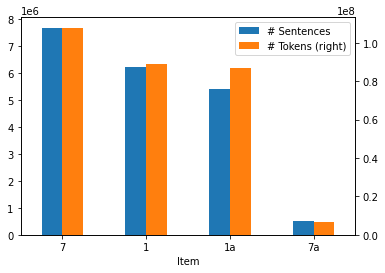

In [13]:
nsents.set_index('Item').join(ntokens.set_index('Item')).plot.bar(secondary_y='# Tokens', rot=0);

In [ ]:
ngrams = pd.read_parquet(sec_path / 'ngrams.parquet')

In [ ]:
ngrams.info()

In [ ]:
ngrams.head()

In [ ]:
ngrams.score.describe(percentiles=percentiles)

In [ ]:
ngrams[ngrams.score>.7].sort_values(['length', 'score']).head(10)

In [15]:
vocab = pd.read_csv(stats_path / 'sections_vocab.csv').dropna()

In [16]:
vocab.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200867 entries, 0 to 200868
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   token   200867 non-null  object
 1   n       200867 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 4.6+ MB


In [19]:
vocab.n.describe(percentiles).astype(int)

count     200867
mean        1439
std        22312
min            1
10%            1
20%            2
30%            3
40%            4
50%            7
60%           12
70%           24
80%           61
90%          260
max      2574572
Name: n, dtype: int64

In [20]:
tokens = Counter()
for l in (ngram_path / 'ngrams_2.txt').open():
    tokens.update(l.split())

In [21]:
tokens = pd.DataFrame(tokens.most_common(),
                     columns=['token', 'count'])

In [22]:
tokens.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230112 entries, 0 to 230111
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   token   230112 non-null  object
 1   count   230112 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.5+ MB


In [23]:
tokens.head()

,token,count
0,million,2340187
1,business,1696732
2,december,1512367
3,company,1490617
4,products,1367413


In [24]:
tokens.loc[tokens.token.str.contains('_'), 'count'].describe(percentiles).astype(int)

count     29951
mean        926
std        9611
min           1
10%          26
20%          31
30%          37
40%          46
50%          61
60%          85
70%         131
80%         237
90%         666
max      593859
Name: count, dtype: int64

In [25]:
tokens[tokens.token.str.contains('_')].head(20).to_csv(sec_path / 'ngram_examples.csv', index=False)

In [26]:
tokens[tokens.token.str.contains('_')].head(20)

,token,count
46,year_ended,593859
64,results_operations,492047
71,table_contents,436034
78,company_s,412971
85,financial_condition,396164
86,common_stock,387629
107,fair_value,341108
152,united_states,276401
158,cash_flows,266725
168,financial_statements,255115


## Get returns

In [27]:
DATA_FOLDER = Path('..', 'data')

In [28]:
with pd.HDFStore(DATA_FOLDER / 'assets.h5') as store:
    prices = store['quandl/wiki/prices'].adj_close

In [29]:
sec = pd.read_csv(sec_path / 'filing_index.csv').rename(columns=str.lower)
sec.date_filed = pd.to_datetime(sec.date_filed)

In [30]:
sec.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22631 entries, 0 to 22630
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   cik           22631 non-null  int64         
 1   company_name  22631 non-null  object        
 2   form_type     22631 non-null  object        
 3   date_filed    22631 non-null  datetime64[ns]
 4   edgar_link    22631 non-null  object        
 5   quarter       22631 non-null  int64         
 6   ticker        22631 non-null  object        
 7   sic           22461 non-null  object        
 8   exchange      20619 non-null  object        
 9   hits          22555 non-null  object        
 10  year          22631 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(7)
memory usage: 1.9+ MB


In [31]:
idx = pd.IndexSlice

In [32]:
first = sec.date_filed.min() + relativedelta(months=-1)
last = sec.date_filed.max() + relativedelta(months=1)
prices = (prices
          .loc[idx[first:last, :]]
          .unstack().resample('D')
          .ffill()
          .dropna(how='all', axis=1)
          .filter(sec.ticker.unique()))

In [33]:
sec = sec.loc[sec.ticker.isin(prices.columns), ['ticker', 'date_filed']]

price_data = []
for ticker, date in sec.values.tolist():
    target = date + relativedelta(months=1)
    s = prices.loc[date: target, ticker]
    price_data.append(s.iloc[-1] / s.iloc[0] - 1)

df = pd.DataFrame(price_data,
                  columns=['returns'],
                  index=sec.index)

In [34]:
df.returns.describe()       

count    11101.000000
mean         0.022839
std          0.126137
min         -0.555556
25%         -0.032213
50%          0.017349
75%          0.067330
max          1.928826
Name: returns, dtype: float64

In [35]:
sec['returns'] = price_data
sec.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11375 entries, 0 to 22629
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   ticker      11375 non-null  object        
 1   date_filed  11375 non-null  datetime64[ns]
 2   returns     11101 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 355.5+ KB


In [36]:
sec.dropna().to_csv(sec_path / 'sec_returns.csv', index=False)